# Oral Insulin Phase II: Clinical Trial



### Dataset:
*(Disclaimer: The clinical dataset is fabricated for the sake of data wrangling practice on Udacity. It is constructed to simulate real-world dataset with the consults of real doctors. The 'auralin' and 'novodra' are NOT real insulin products, however, it mimics the real clinical trial for an inhaled insulin, Afrezza.)*
> The increasing number of patients with diabetes is alarming. Despite the discovery of insulin in the 1920s, it has been a challenge that the default method is needle administration multiple times a day. In search for new method, researchers conducted a phase II clinical trial of 350 patients for a new innovative oral insulin capsule, Auralin.<br>
 In order to evaluate the efficacy of Auralin, the trial treated half of the patients with Auralin whilst the other 175 being treated with injectable insulin, Novodra. 

1. Patients table:
* patients_id, 
* assigned_sex, 
* given_name, 
* surname, 
* address, 
* city, 
* state, 
* zip_code, 
* country, 
* contact, 
* birthdate, 
* weight, 
* height, 
* bmi

2. Treatments table:
* given_name, 
* surname, 
* auralin, 
* novodra, 
* hba1c_start,  
* hba1c_end, 
* hba1c_change
3. Adverse reactions table:
* given_name, 
* surname,
* adverse_reaction



## Gather

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read datasets
patients = pd.read_csv('../input/phase-ii-oral-insulin/patients.csv')
treatments = pd.read_csv('../input/phase-ii-oral-insulin/treatments.csv')
adverse_reactions = pd.read_csv('../input/phase-ii-oral-insulin/adverse_reactions.csv')
treatments_cut = pd.read_csv('../input/phase-ii-oral-insulin/treatments_cut.csv')

## Assess
> Assess the datasets visually and programmatically

In [3]:
patients

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,contact,birthdate,weight,height,bmi
0,1,female,Zoe,Wellish,576 Brown Bear Drive,Rancho California,California,92390.0,United States,951-719-9170ZoeWellish@superrito.com,7/10/1976,121.7,66,19.6
1,2,female,Pamela,Hill,2370 University Hill Road,Armstrong,Illinois,61812.0,United States,PamelaSHill@cuvox.de+1 (217) 569-3204,4/3/1967,118.8,66,19.2
2,3,male,Jae,Debord,1493 Poling Farm Road,York,Nebraska,68467.0,United States,402-363-6804JaeMDebord@gustr.com,2/19/1980,177.8,71,24.8
3,4,male,Liêm,Phan,2335 Webster Street,Woodbridge,NJ,7095.0,United States,PhanBaLiem@jourrapide.com+1 (732) 636-8246,7/26/1951,220.9,70,31.7
4,5,male,Tim,Neudorf,1428 Turkey Pen Lane,Dothan,AL,36303.0,United States,334-515-7487TimNeudorf@cuvox.de,2/18/1928,192.3,27,26.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,499,male,Mustafa,Lindström,2530 Victoria Court,Milton Mills,ME,3852.0,United States,207-477-0579MustafaLindstrom@jourrapide.com,4/10/1959,181.1,72,24.6
499,500,male,Ruman,Bisliev,494 Clarksburg Park Road,Sedona,AZ,86341.0,United States,928-284-4492RumanBisliev@gustr.com,3/26/1948,239.6,70,34.4
500,501,female,Jinke,de Keizer,649 Nutter Street,Overland Park,MO,64110.0,United States,816-223-6007JinkedeKeizer@teleworm.us,1/13/1971,171.2,67,26.8
501,502,female,Chidalu,Onyekaozulu,3652 Boone Crockett Lane,Seattle,WA,98109.0,United States,ChidaluOnyekaozulu@jourrapide.com1 360 443 2060,2/13/1952,176.9,67,27.7


In [4]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   patient_id    503 non-null    int64  
 1   assigned_sex  503 non-null    object 
 2   given_name    503 non-null    object 
 3   surname       503 non-null    object 
 4   address       491 non-null    object 
 5   city          491 non-null    object 
 6   state         491 non-null    object 
 7   zip_code      491 non-null    float64
 8   country       491 non-null    object 
 9   contact       491 non-null    object 
 10  birthdate     503 non-null    object 
 11  weight        503 non-null    float64
 12  height        503 non-null    int64  
 13  bmi           503 non-null    float64
dtypes: float64(3), int64(2), object(9)
memory usage: 55.1+ KB


In [5]:
patients.describe()

,patient_id,zip_code,weight,height,bmi
count,503.000000,491.000000,503.000000,503.000000,503.000000
mean,252.000000,49084.118126,173.434990,66.634195,27.483897
std,145.347859,30265.807442,33.916741,4.411297,5.276438
min,1.000000,1002.000000,48.800000,27.000000,17.100000
25%,126.500000,21920.500000,149.300000,63.000000,23.300000
50%,252.000000,48057.000000,175.300000,67.000000,27.200000
75%,377.500000,75679.000000,199.500000,70.000000,31.750000
max,503.000000,99701.000000,255.900000,79.000000,37.700000


In [6]:
patients.dtypes

patient_id        int64
assigned_sex     object
given_name       object
surname          object
address          object
city             object
state            object
zip_code        float64
country          object
contact          object
birthdate        object
weight          float64
height            int64
bmi             float64
dtype: object

In [7]:
patients.query("weight <=90")

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,contact,birthdate,weight,height,bmi
210,211,female,Camilla,Zaitseva,4689 Briarhill Lane,Wooster,OH,44691.0,United States,330-202-2145CamillaZaitseva@superrito.com,11/26/1938,48.8,63,19.1


In [8]:
patients.query("height == height.min()")

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,contact,birthdate,weight,height,bmi
4,5,male,Tim,Neudorf,1428 Turkey Pen Lane,Dothan,AL,36303.0,United States,334-515-7487TimNeudorf@cuvox.de,2/18/1928,192.3,27,26.1


In [9]:
treatments

,given_name,surname,auralin,novodra,hba1c_start,hba1c_end,hba1c_change
0,veronika,jindrová,41u - 48u,-,7.63,7.20,NaN
1,elliot,richardson,-,40u - 45u,7.56,7.09,0.97
2,yukitaka,takenaka,-,39u - 36u,7.68,7.25,NaN
3,skye,gormanston,33u - 36u,-,7.97,7.62,0.35
4,alissa,montez,-,33u - 29u,7.78,7.46,0.32
...,...,...,...,...,...,...,...
275,albina,zetticci,45u - 51u,-,7.93,7.73,0.20
276,john,teichelmann,-,49u - 49u,7.90,7.58,NaN
277,mathea,lillebø,23u - 36u,-,9.04,8.67,0.37
278,vallie,prince,31u - 38u,-,7.64,7.28,0.36


In [10]:
treatments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   given_name    280 non-null    object 
 1   surname       280 non-null    object 
 2   auralin       280 non-null    object 
 3   novodra       280 non-null    object 
 4   hba1c_start   280 non-null    float64
 5   hba1c_end     280 non-null    float64
 6   hba1c_change  171 non-null    float64
dtypes: float64(3), object(4)
memory usage: 15.4+ KB


In [11]:
treatments.describe()

,hba1c_start,hba1c_end,hba1c_change
count,280.000000,280.000000,171.000000
mean,7.985929,7.589286,0.546023
std,0.568638,0.569672,0.279555
min,7.500000,7.010000,0.200000
25%,7.660000,7.270000,0.340000
50%,7.800000,7.420000,0.380000
75%,7.970000,7.570000,0.920000
max,9.950000,9.580000,0.990000


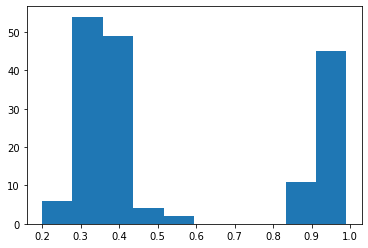

In [12]:
plt.hist(treatments['hba1c_change']);

In [13]:
treatments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   given_name    280 non-null    object 
 1   surname       280 non-null    object 
 2   auralin       280 non-null    object 
 3   novodra       280 non-null    object 
 4   hba1c_start   280 non-null    float64
 5   hba1c_end     280 non-null    float64
 6   hba1c_change  171 non-null    float64
dtypes: float64(3), object(4)
memory usage: 15.4+ KB


In [14]:
adverse_reactions

,given_name,surname,adverse_reaction
0,berta,napolitani,injection site discomfort
1,lena,baer,hypoglycemia
2,joseph,day,hypoglycemia
3,flavia,fiorentino,cough
4,manouck,wubbels,throat irritation
5,jasmine,sykes,hypoglycemia
6,louise,johnson,hypoglycemia
7,albinca,komavec,hypoglycemia
8,noe,aranda,hypoglycemia
9,sofia,hermansen,injection site discomfort


### Initial Assessment Report
> #### Tidiness
- `contact` column in `patients` table contains two pieces of info and should be split into two columns (`email`, `phone_number`)
- Three variables are included in two columns in `treatments` table (treatment, start dose, end dose)
- `adverse_reactions` table is non-necessary and should be merged into `treatments` table
- Duplicated columns (`given_name`, `surname`) in `patients` table and `treatments` table


> #### Quality
##### `patients` table
- Zip code is a float, not a string
- Some `zip_code` has only 4 digits 
- Errorneous datatypes (assigned_sex, state, zip_code, birthdate) columns
- Inconsistencies in `state` where some entries are abbreviation and others are full name
- min() height is 27 which is invalid
- min() weight 48.8kgs --> lbs 
- Typo Dsvid Gustafsson
- Missing demographic information in `address`, `contact` columns which cannot be fixed arbitrarily
- Mulpitle phone number formats (e.g. +12, (xxx), xxx)
- Default John Doe data
- Multiple records for Jakobsen, Gersten, Taylor

##### `treatments` table
- Missing records: should be 280 --> 350 cases
- Missing hba1c changes
- 'u' in start & end dose for auralin and novodra
- Lowercase given_names and surname (inconsistent with other tables)
- Erroneous datatypes (`auralin` and `novodra`)
- Inaccurate hba1c change: 9s (invalidly high change) --> 4s
- Dashes (-) representing nulls in `auralin`, `novodra`

## Clean
> For efficacy, clean the missing values and structural issues (tidiness) first, and then move on to data quality issues

In [15]:
# Before any cleaning, make copies of dataset
patients_clean = patients.copy()
treatments_clean = treatments.copy()
reactions_clean = adverse_reactions.copy()

#### Clean 1
##### Define: missing records in treatments table
* Concatenate `treatment_cut` into `treatment` table to include missing entries and make it 280-->350 entries: .concat()
* Calculate missing and inaccurate hba1c (e.g. 9s) in `hba1c_change` column: `hba1c_start`-`hba1c_end`

In [16]:
# Before concatenating, check if the columns in two dataframes match
treatments_clean.columns == treatments_cut.columns

array([ True,  True,  True,  True,  True,  True,  True])

In [17]:
# See the number of duplicates patients to determine if the two tables are seperate record of patients
# If there is high number of duplicates, it indicates the two tables are merely duplicated records

full_name1 = pd.DataFrame(treatments_clean['given_name'] + ' ' + treatments_clean['surname'])
full_name2 = pd.DataFrame(treatments_cut['given_name'] + ' ' + treatments_cut['surname'])

full_name = pd.concat([full_name1, full_name2], ignore_index=True)

full_name[full_name.duplicated()]

# Since there is only 1 duplicate, and it comes from the `treatments_clean` table
# Therefore, it is highly certain that the two tables are NOT duplicated record of patients

,0
136,joseph day


In [18]:
treatments_clean.query("given_name=='joseph' and surname=='day'")

# Drop one of the duplicated rows
treatments_clean.drop(10, axis=0, inplace=True)

# Confirm
treatments_clean.query("given_name=='joseph' and surname=='day'")


,given_name,surname,auralin,novodra,hba1c_start,hba1c_end,hba1c_change
136,joseph,day,29u - 36u,-,7.7,7.19,NaN


In [19]:
# Now, concatenate the tables
treatments_clean = pd.concat([treatments_clean, treatments_cut], ignore_index=True)

In [20]:
# Calculate missing hba1c_change
treatments_clean.hba1c_change = treatments_clean.hba1c_start - treatments_clean.hba1c_end

In [21]:
# Check if concatenation and calculation is successful
treatments_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   given_name    349 non-null    object 
 1   surname       349 non-null    object 
 2   auralin       349 non-null    object 
 3   novodra       349 non-null    object 
 4   hba1c_start   349 non-null    float64
 5   hba1c_end     349 non-null    float64
 6   hba1c_change  349 non-null    float64
dtypes: float64(3), object(4)
memory usage: 19.2+ KB


#### Clean 2
##### Define: two information in one column
* Split the `contact` column in `patients_clean` table by extracting 'email' and 'phone number':
    * .str.extract() / .split(expand=True) / .drop()

In [22]:
# Assess the form of messy contact details
patients_clean.contact.sample(50)

370                       508-821-2421OlofHolm@gustr.com
108              MarinaGlockner@dayrep.com1 620 940 1131
58         YasminCardosoAraujo@superrito.com412-640-7035
316                 413-259-3637BuiQuynhChan@fleckens.hu
334                 630-837-9473EugeneMironov@dayrep.com
378                  FurutaOsman@rhyta.com1 901 316 3780
377        217-485-5673CumelenMiramontesAcosta@gustr.com
287            KariLaatikainen@fleckens.hu1 619 818 3436
142                516-740-5280FinleyChandler@dayrep.com
444             415-277-2563AngelicoMarchesi@fleckens.hu
114               917-256-5329YunadiBarsukov@teleworm.us
110        MiroslavStepanek@teleworm.us+1 (214) 637-0855
362                     757-624-1525LubosPecha@rhyta.com
160                FlavianoEndrizzi@cuvox.de602-993-7880
445                 MaximusHenzen@einrot.com408-792-9489
306         402-780-5724MijndertOuwendijk@jourrapide.com
285                     AydenAllan@rhyta.com580-991-9678
403                 RobertMaslo

In [23]:
# Extract the two different information and create two columns for each
patients_clean['phone_number'] = patients_clean.contact.str.extract('((?:\+?\d{1,2}[\s.-])?\(?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4})', expand=True)
patients_clean['email'] = patients_clean.contact.str.extract('([a-zA-Z][a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.][a-zA-Z]+)', expand=True)

# Drop the `contact` column
patients_clean.drop(columns = 'contact', inplace=True)

In [24]:
patients_clean

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
0,1,female,Zoe,Wellish,576 Brown Bear Drive,Rancho California,California,92390.0,United States,7/10/1976,121.7,66,19.6,951-719-9170,ZoeWellish@superrito.com
1,2,female,Pamela,Hill,2370 University Hill Road,Armstrong,Illinois,61812.0,United States,4/3/1967,118.8,66,19.2,+1 (217) 569-3204,PamelaSHill@cuvox.de
2,3,male,Jae,Debord,1493 Poling Farm Road,York,Nebraska,68467.0,United States,2/19/1980,177.8,71,24.8,402-363-6804,JaeMDebord@gustr.com
3,4,male,Liêm,Phan,2335 Webster Street,Woodbridge,NJ,7095.0,United States,7/26/1951,220.9,70,31.7,+1 (732) 636-8246,PhanBaLiem@jourrapide.com
4,5,male,Tim,Neudorf,1428 Turkey Pen Lane,Dothan,AL,36303.0,United States,2/18/1928,192.3,27,26.1,334-515-7487,TimNeudorf@cuvox.de
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,499,male,Mustafa,Lindström,2530 Victoria Court,Milton Mills,ME,3852.0,United States,4/10/1959,181.1,72,24.6,207-477-0579,MustafaLindstrom@jourrapide.com
499,500,male,Ruman,Bisliev,494 Clarksburg Park Road,Sedona,AZ,86341.0,United States,3/26/1948,239.6,70,34.4,928-284-4492,RumanBisliev@gustr.com
500,501,female,Jinke,de Keizer,649 Nutter Street,Overland Park,MO,64110.0,United States,1/13/1971,171.2,67,26.8,816-223-6007,JinkedeKeizer@teleworm.us
501,502,female,Chidalu,Onyekaozulu,3652 Boone Crockett Lane,Seattle,WA,98109.0,United States,2/13/1952,176.9,67,27.7,1 360 443 2060,ChidaluOnyekaozulu@jourrapide.com


#### Clean 3
##### Define: three variables in two columns
* Melt the `auralin` and `novodra` columns to a `treatment` and `dose` column: pd.melt()
* Then, split the `dose` column into `start_dose` and `end_dose` with '-' as a seperator: str.split()
* Drop the original dose column: .drop()

* Remove 'u' from start_dose and end_dose, and convert datatype to integer

In [25]:
# Melt the columns
treatments_clean = pd.melt(treatments_clean, id_vars=['given_name', 'surname', 'hba1c_start', 'hba1c_end', 'hba1c_change'], value_vars = ['auralin', 'novodra'], var_name ='treatment', value_name='dose')

In [26]:
# Drop rows with dose value of '-'
treatments_clean = treatments_clean[treatments_clean.dose != '-']

In [27]:
# Split into start / end dose columns
treatments_clean[['dose_start', 'dose_end']] = treatments_clean.dose.str.split(' - ', 1, expand=True)

In [28]:
# Drop the original dose column
treatments_clean.drop('dose', axis=1, inplace=True)

In [29]:
# Remove 'u' and convert the datatype to integer
treatments_clean.dose_start = treatments_clean.dose_start.str[:-1].astype(int)
treatments_clean.dose_end = treatments_clean.dose_end.str[:-1].astype(int)

In [30]:
# Confirm
treatments_clean.dtypes

given_name       object
surname          object
hba1c_start     float64
hba1c_end       float64
hba1c_change    float64
treatment        object
dose_start        int64
dose_end          int64
dtype: object

In [31]:
treatments_clean.head()

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,dose_start,dose_end
0,veronika,jindrová,7.63,7.20,0.43,auralin,41,48
3,skye,gormanston,7.97,7.62,0.35,auralin,33,36
6,sophia,haugen,7.65,7.27,0.38,auralin,37,42
7,eddie,archer,7.89,7.55,0.34,auralin,31,38
9,asia,woźniak,7.76,7.37,0.39,auralin,30,36


#### Clean 4
##### Define: unnecessary table
* Merge the `adverse_reactions` table to the `treatments` table: pd.merge()

In [32]:
# Merge two tables 
pd.merge(treatments_clean, reactions_clean, 
         on=['given_name', 'surname'], how='left')

# Now that the 'adverse reaction' information is merged into the treatment table, we no longer need the adverse reactions table

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,dose_start,dose_end,adverse_reaction
0,veronika,jindrová,7.63,7.20,0.43,auralin,41,48,NaN
1,skye,gormanston,7.97,7.62,0.35,auralin,33,36,NaN
2,sophia,haugen,7.65,7.27,0.38,auralin,37,42,NaN
3,eddie,archer,7.89,7.55,0.34,auralin,31,38,NaN
4,asia,woźniak,7.76,7.37,0.39,auralin,30,36,NaN
...,...,...,...,...,...,...,...,...,...
344,christopher,woodward,7.51,7.06,0.45,novodra,55,51,nausea
345,maret,sultygov,7.67,7.30,0.37,novodra,26,23,NaN
346,lixue,hsueh,9.21,8.80,0.41,novodra,22,23,injection site discomfort
347,jakob,jakobsen,7.96,7.51,0.45,novodra,28,26,hypoglycemia


#### Clean 5
##### Define: duplicate columns
* Isolate the `patient_id` and `names` in the patients table and join with treatments table:
    * make sure to lowercase the names to match the treatments table: str.lower()
* Then, drop those name columns from the treatments table

In [33]:
# Isolate and lowercase
id_name = patients_clean[['patient_id', 'given_name', 'surname']]
id_name.given_name = id_name.given_name.str.lower()
id_name.surname = id_name.surname.str.lower()

id_name

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,patient_id,given_name,surname
0,1,zoe,wellish
1,2,pamela,hill
2,3,jae,debord
3,4,liêm,phan
4,5,tim,neudorf
...,...,...,...
498,499,mustafa,lindström
499,500,ruman,bisliev
500,501,jinke,de keizer
501,502,chidalu,onyekaozulu


In [34]:
# Merge the id_name table to treatments
treatments_clean = pd.merge(treatments_clean, id_name, on=['given_name', 'surname'])

# As we now have the identifier column `patient_id` in the table, drop the name columns 
treatments_clean.drop(['given_name', 'surname'], axis=1, inplace=True)

In [35]:
# Confirm: patient_id should only be the duplicate column now
all_col = pd.Series(list(patients_clean) + list(treatments_clean))
all_col[all_col.duplicated()]

21    patient_id
dtype: object

#### Quality
* Errorneous datatypes (assigned_sex, state, zip_code, birthdate) columns
* Some zip_code has only 4 digits
* Inconsistencies in state where some entries are abbreviation and others are full name
* min() height is 27 which is invalid
* min() weight 48.8kgs --> lbs
* Typo Dsvid Gustafsson
* Missing demographic information in address, contact columns which cannot be arbitrarily filled
* Mulpitle phone number formats (e.g. +12, (xxx), xxx)
* Default John Doe data
* Multiple records for Jakobsen, Gersten, Taylor

#### Clean 6
##### Define: wrong datatypes
* Convert dtypes: ['assigned_sex', 'state']: category / ['zip_code']: str / 'birthdate': to_datetime

In [36]:
# assigned_sex and state
patients_clean.assigned_sex = patients_clean.assigned_sex.astype('category')
patients_clean.state = patients_clean.state.astype('category')

In [37]:
# Convert the zip code column's data type from a float to a string using astype, remove the '.0' using string slicing
patients_clean.zip_code = patients_clean.zip_code.astype(str).str[:-2]

# Then pad four digit zip codes with a leading 0
patients_clean.zip_code = patients_clean.zip_code.str.pad(5, side='left', fillchar='0') 

# Reconvert NaN entries that were converted to 0000n due to the code above
patients_clean.zip_code = patients_clean.zip_code.replace('0000n', np.nan)

In [38]:
# Convert birthdate
patients_clean.birthdate = pd.to_datetime(patients_clean['birthdate'])

In [39]:
# Confirm the changes
patients_clean.dtypes

patient_id               int64
assigned_sex          category
given_name              object
surname                 object
address                 object
city                    object
state                 category
zip_code                object
country                 object
birthdate       datetime64[ns]
weight                 float64
height                   int64
bmi                    float64
phone_number            object
email                   object
dtype: object

#### Clean 7
##### Define: inconsistencies in state
* Fix inconsistencies in state where some entries are abbreviation and others are full name: define a function

In [40]:
# Check the state entries to see what states are in full name
patients_clean.state.value_counts()

California    36
TX            32
New York      25
CA            24
NY            22
MA            22
PA            18
GA            15
Illinois      14
OH            14
MI            13
LA            13
Florida       13
OK            13
NJ            12
VA            11
WI            10
IL            10
MS            10
TN             9
AL             9
MN             9
FL             9
IN             9
KY             8
WA             8
NC             8
MO             7
KS             6
ID             6
NV             6
IA             5
SC             5
CT             5
ME             4
Nebraska       4
CO             4
AZ             4
ND             4
AR             4
RI             4
SD             3
MD             3
OR             3
DE             3
WV             3
DC             2
NE             2
MT             2
VT             2
AK             1
NM             1
NH             1
WY             1
Name: state, dtype: int64

In [41]:
# Create a abbreviation dictionary for states in full name: California, New York, Illinois, Florida, Nebraska
state_abbrev = {'California': 'CA', 'New York': 'NY',
         'Illinois': 'IL', 'Florida': 'FL',
         'Nebraska': 'NE'}

In [42]:
# Create a function that changes full name to abbreviations
def abbrev_state(dataframe):
    if dataframe['state'] in state_abbrev.keys():
        abbrev = state_abbrev[dataframe['state']]
        return abbrev
    else:
        return dataframe['state']

# Apply the function to the table
patients_clean['state'] = patients_clean.apply(abbrev_state, axis=1)

In [43]:
# Confirm. There should only be abbreviations. 
patients_clean.state.value_counts()

CA    60
NY    47
TX    32
IL    24
FL    22
MA    22
PA    18
GA    15
OH    14
MI    13
OK    13
LA    13
NJ    12
VA    11
WI    10
MS    10
AL     9
TN     9
IN     9
MN     9
NC     8
KY     8
WA     8
MO     7
NE     6
KS     6
ID     6
NV     6
SC     5
IA     5
CT     5
RI     4
ND     4
AR     4
AZ     4
ME     4
CO     4
MD     3
DE     3
SD     3
WV     3
OR     3
VT     2
MT     2
DC     2
AK     1
NM     1
NH     1
WY     1
Name: state, dtype: int64

#### Clean 8
##### Define: miscellaneous
* Convert invalid height, weight
* Fix typo: .replace()

In [44]:
# Convert the invalid '27' height to 72
patients_clean.height = patients_clean.height.replace(27, 72)

In [45]:
# Convert minimum weight '48.8' kg to lbs
# First, get the info about patient with minimum weight 48.8kg
patients_clean[patients_clean['weight'] == patients_clean.weight.min()]

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
210,211,female,Camilla,Zaitseva,4689 Briarhill Lane,Wooster,OH,44691,United States,1938-11-26,48.8,63,19.1,330-202-2145,CamillaZaitseva@superrito.com


In [46]:
# Create variables and mask
kg = patients_clean.weight.min()
mask = patients_clean.surname == 'Zaitseva'
column_name = 'weight'

# Calculate weight(kg)*2.20462 to get weight(lbs)
patients_clean.loc[mask, column_name] = kg*2.20462

# Recalculate bmi with amended lbs weight
lbs = patients_clean[patients_clean.surname=='Zaitseva'].weight
height = patients_clean[patients_clean.surname=='Zaitseva'].height
column_name = 'bmi'
patients_clean.loc[mask, column_name] = 703 * lbs / (height * height)

In [47]:
# Confirm
patients_clean.query("surname == 'Zaitseva'")

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
210,211,female,Camilla,Zaitseva,4689 Briarhill Lane,Wooster,OH,44691,United States,1938-11-26,107.585456,63,19.055827,330-202-2145,CamillaZaitseva@superrito.com


In [48]:
# Fix typo
patients_clean.given_name = patients_clean.given_name.replace('Dsvid', 'David')

In [49]:
# Confirm
patients_clean.query('surname == "Gustafsson"')

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
8,9,male,David,Gustafsson,1790 Nutter Street,Kansas City,MO,64105,United States,1937-03-06,163.9,66,26.5,816-265-9578,DavidGustafsson@armyspy.com


#### Clean 9
##### Define: inconsistencies in phone number
* Make phone_number consistent by stripping all non-digits: " ", "-", "(", ")", "+" 
* Store each number without any formatting
* Pad 10 digit phone_number with a 1 (the US country code) 

In [50]:
patients_clean.phone_number = patients_clean.phone_number.str.replace(r'\D+','').str.pad(11, fillchar='1')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [51]:
# Confirm
patients_clean.head()

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
0,1,female,Zoe,Wellish,576 Brown Bear Drive,Rancho California,CA,92390,United States,1976-07-10,121.7,66,19.6,19517199170,ZoeWellish@superrito.com
1,2,female,Pamela,Hill,2370 University Hill Road,Armstrong,IL,61812,United States,1967-04-03,118.8,66,19.2,12175693204,PamelaSHill@cuvox.de
2,3,male,Jae,Debord,1493 Poling Farm Road,York,NE,68467,United States,1980-02-19,177.8,71,24.8,14023636804,JaeMDebord@gustr.com
3,4,male,Liêm,Phan,2335 Webster Street,Woodbridge,NJ,07095,United States,1951-07-26,220.9,70,31.7,17326368246,PhanBaLiem@jourrapide.com
4,5,male,Tim,Neudorf,1428 Turkey Pen Lane,Dothan,AL,36303,United States,1928-02-18,192.3,72,26.1,13345157487,TimNeudorf@cuvox.de


In [52]:
patients_clean.given_name = patients_clean.given_name.replace('Dsvid', 'David')

# Confirm
patients_clean.query('surname == "Gustafsson"')

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
8,9,male,David,Gustafsson,1790 Nutter Street,Kansas City,MO,64105,United States,1937-03-06,163.9,66,26.5,18162659578,DavidGustafsson@armyspy.com


#### Clean 10
##### Define: duplicates John Doe
* Eliminate duplicate rows

In [53]:
# Get row indices
patients_clean.query('surname == "Doe"')

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
215,216,male,John,Doe,123 Main Street,New York,NY,12345,United States,1975-01-01,180.0,72,24.4,11234567890,johndoe@email.com
229,230,male,John,Doe,123 Main Street,New York,NY,12345,United States,1975-01-01,180.0,72,24.4,11234567890,johndoe@email.com
237,238,male,John,Doe,123 Main Street,New York,NY,12345,United States,1975-01-01,180.0,72,24.4,11234567890,johndoe@email.com
244,245,male,John,Doe,123 Main Street,New York,NY,12345,United States,1975-01-01,180.0,72,24.4,11234567890,johndoe@email.com
251,252,male,John,Doe,123 Main Street,New York,NY,12345,United States,1975-01-01,180.0,72,24.4,11234567890,johndoe@email.com
277,278,male,John,Doe,123 Main Street,New York,NY,12345,United States,1975-01-01,180.0,72,24.4,11234567890,johndoe@email.com


In [54]:
# Drop rows
patients_clean.drop([229, 237, 244, 251, 277], axis=0, inplace=True)

# Confirm
patients_clean.query('surname =="Doe"')

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
215,216,male,John,Doe,123 Main Street,New York,NY,12345,United States,1975-01-01,180.0,72,24.4,11234567890,johndoe@email.com


#### Clean 11
##### Define: multiple records for Jakobsen, Gersten, Taylor (It is highly likely that Jake and Jakob living in the same street, has same email account, same phone number, same height/weight are two different persons. This means it is recorded multiple times).
* Remove multiple records

In [55]:
patients_clean[patients_clean.address.duplicated()]

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
29,30,male,Jake,Jakobsen,648 Old Dear Lane,Port Jervis,NY,12771,United States,1985-08-01,155.8,67,24.4,18458587707,JakobCJakobsen@einrot.com
219,220,male,Mỹ,Quynh,NaN,NaN,NaN,NaN,NaN,1978-04-09,237.8,69,35.1,NaN,NaN
230,231,female,Elisabeth,Knudsen,NaN,NaN,NaN,NaN,NaN,1976-09-23,165.9,63,29.4,NaN,NaN
234,235,female,Martina,Tománková,NaN,NaN,NaN,NaN,NaN,1936-04-07,199.5,65,33.2,NaN,NaN
242,243,male,John,O'Brian,NaN,NaN,NaN,NaN,NaN,1957-02-25,205.3,74,26.4,NaN,NaN
249,250,male,Benjamin,Mehler,NaN,NaN,NaN,NaN,NaN,1951-10-30,146.5,69,21.6,NaN,NaN
257,258,male,Jin,Kung,NaN,NaN,NaN,NaN,NaN,1995-05-17,231.7,69,34.2,NaN,NaN
264,265,female,Wafiyyah,Asfour,NaN,NaN,NaN,NaN,NaN,1989-11-03,158.6,63,28.1,NaN,NaN
269,270,female,Flavia,Fiorentino,NaN,NaN,NaN,NaN,NaN,1937-10-09,175.2,61,33.1,NaN,NaN
278,279,female,Generosa,Cabán,NaN,NaN,NaN,NaN,NaN,1962-12-16,124.3,69,18.4,NaN,NaN


In [56]:
patients_clean.query("surname == 'Jakobsen'")

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
24,25,male,Jakob,Jakobsen,648 Old Dear Lane,Port Jervis,NY,12771,United States,1985-08-01,155.8,67,24.4,18458587707,JakobCJakobsen@einrot.com
29,30,male,Jake,Jakobsen,648 Old Dear Lane,Port Jervis,NY,12771,United States,1985-08-01,155.8,67,24.4,18458587707,JakobCJakobsen@einrot.com
432,433,female,Karen,Jakobsen,1690 Fannie Street,Houston,TX,77020,United States,1962-11-25,185.2,67,29.0,19792030438,KarenJakobsen@jourrapide.com


In [57]:
patients_clean.query("surname == 'Gersten'")

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
97,98,male,Patrick,Gersten,2778 North Avenue,Burr,NE,68324,United States,1954-05-03,138.2,71,19.3,14028484923,PatrickGersten@rhyta.com
502,503,male,Pat,Gersten,2778 North Avenue,Burr,NE,68324,United States,1954-05-03,138.2,71,19.3,14028484923,PatrickGersten@rhyta.com


In [58]:
patients_clean.query("surname == 'Taylor'")

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
131,132,female,Sandra,Taylor,2476 Fulton Street,Rainelle,WV,25962,United States,1960-10-23,206.1,64,35.4,13044382648,SandraCTaylor@dayrep.com
282,283,female,Sandy,Taylor,2476 Fulton Street,Rainelle,WV,25962,United States,1960-10-23,206.1,64,35.4,13044382648,SandraCTaylor@dayrep.com
426,427,male,Rogelio,Taylor,4064 Marigold Lane,Miami,FL,33179,United States,1992-09-02,186.6,69,27.6,13054346299,RogelioJTaylor@teleworm.us


In [59]:
# Only include rows with non-duplicate and non-null address.
# tilde means 'not'
patients_clean = patients_clean[~((patients_clean.address.duplicated()) & patients_clean.address.notnull())]

In [60]:
# Confirm
patients_clean.query("surname == 'Taylor' or surname =='Gersten' or surname == 'Jakobsen'")

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
24,25,male,Jakob,Jakobsen,648 Old Dear Lane,Port Jervis,NY,12771,United States,1985-08-01,155.8,67,24.4,18458587707,JakobCJakobsen@einrot.com
97,98,male,Patrick,Gersten,2778 North Avenue,Burr,NE,68324,United States,1954-05-03,138.2,71,19.3,14028484923,PatrickGersten@rhyta.com
131,132,female,Sandra,Taylor,2476 Fulton Street,Rainelle,WV,25962,United States,1960-10-23,206.1,64,35.4,13044382648,SandraCTaylor@dayrep.com
426,427,male,Rogelio,Taylor,4064 Marigold Lane,Miami,FL,33179,United States,1992-09-02,186.6,69,27.6,13054346299,RogelioJTaylor@teleworm.us
432,433,female,Karen,Jakobsen,1690 Fannie Street,Houston,TX,77020,United States,1962-11-25,185.2,67,29.0,19792030438,KarenJakobsen@jourrapide.com
